<a href="https://colab.research.google.com/github/Maazchogle/Semantic_Analysis_for_medical_review-/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
df = pd.read_csv('review_data_500k.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [ ]:
print("Dataset size:", len(df))

Dataset size: 500001


In [ ]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,NO_QUERY,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...
2,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...
3,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...
4,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...


In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
df.target = df.target.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Dataset labels distribuition')

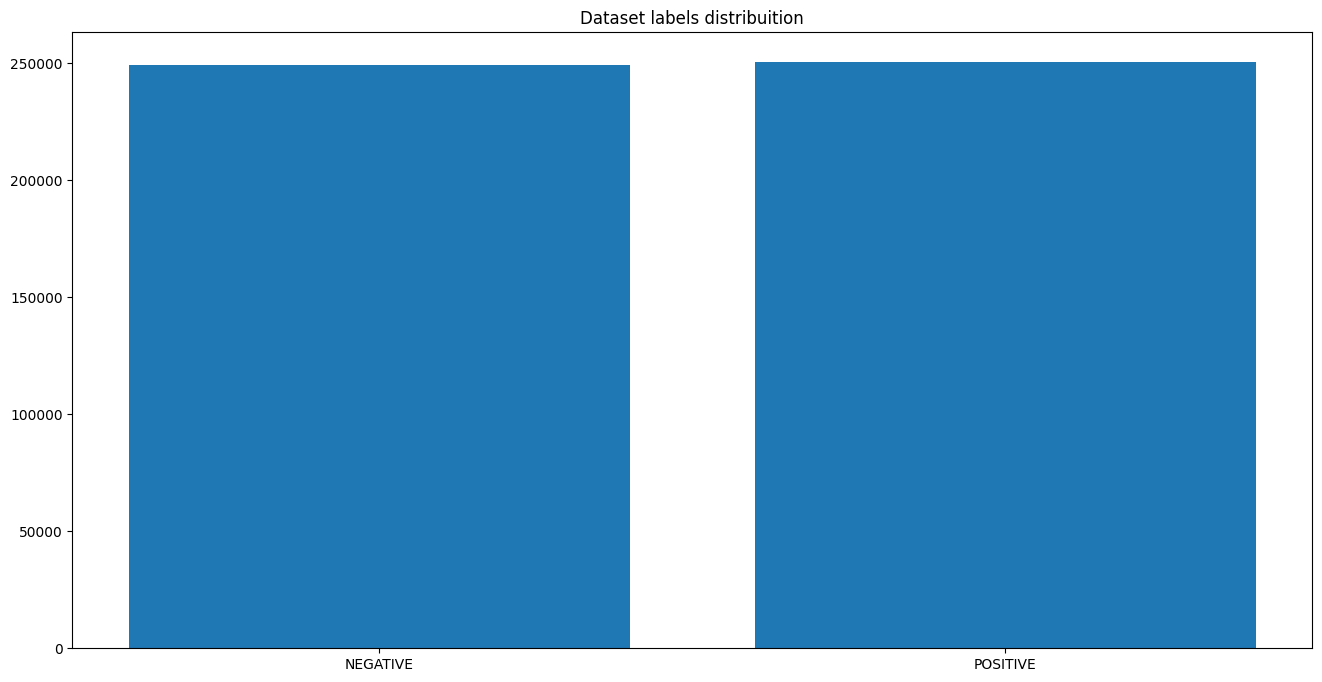

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 400000
TEST size: 100001


In [ ]:
documents = [_text.split() for _text in df_train.text]

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = list(w2v_model.wv.key_to_index.keys())
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 15269


In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(79521125, 92180512)

In [ ]:
w2v_model.wv.most_similar("happy")

[('celebrations', 0.5148706436157227),
 ('celebrated', 0.5052958726882935),
 ('thankful', 0.4991389811038971),
 ('celebrating', 0.4973544776439667),
 ('proud', 0.45629817247390747),
 ('wonderful', 0.4526239335536957),
 ('belated', 0.4403592348098755),
 ('blessed', 0.4345332384109497),
 ('gifts', 0.4263456463813782),
 ('present', 0.42322707176208496)]

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

NameError: name 'Tokenizer' is not defined

In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 7.44 s, sys: 181 ms, total: 7.62 s
Wall time: 7.68 s


In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (400000, 1)
y_test (100001, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (400000, 300)
y_train (400000, 1)

x_test (100001, 300)
y_test (100001, 1)


In [ ]:
y_train[:10]

array([[0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1]])

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(137938, 100)


In [ ]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          13793800  
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 13874301 (52.93 MB)
Trainable params: 80501 (314.46 KB)
Non-trainable params: 13793800 (52.62 MB)
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, cooldown=0, min_lr=0.0000001),
    EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)
]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=20,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)


Epoch 1/20
352/352 [==============================] - ETA: 0s - loss: 0.5582 - accuracy: 0.7096

352/352 [==============================] - 308s 857ms/step - loss: 0.5582 - accuracy: 0.7096 - val_loss: 0.4922 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 2/20
352/352 [==============================] - ETA: 0s - loss: 0.5248 - accuracy: 0.7351

352/352 [==============================] - 303s 860ms/step - loss: 0.5248 - accuracy: 0.7351 - val_loss: 0.4869 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 3/20
352/352 [==============================] - ETA: 0s - loss: 0.5159 - accuracy: 0.7421

352/352 [==============================] - 303s 861ms/step - loss: 0.5159 - accuracy: 0.7421 - val_loss: 0.4844 - val_accuracy: 0.7652 - lr: 0.0010
Epoch 4/20
352/352 [==============================] - ETA: 0s - loss: 0.5112 - accuracy: 0.7452

352/352 [==============================] - 301s 856ms/step - loss: 0.5112 - accuracy: 0.7452 - val_loss: 0.4784 - val_accuracy: 0.7683 - lr: 0.0010
Epoch 5/20
352/352 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.7473

352/352 [==============================] - 301s 854ms/step - loss: 0.5082 - accuracy: 0.7473 - val_loss: 0.4747 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 6/20
352/352 [==============================] - ETA: 0s - loss: 0.5052 - accuracy: 0.7492

352/352 [==============================] - 300s 851ms/step - loss: 0.5052 - accuracy: 0.7492 - val_loss: 0.4746 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 7/20
352/352 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.7507

352/352 [==============================] - 301s 856ms/step - loss: 0.5033 - accuracy: 0.7507 - val_loss: 0.4720 - val_accuracy: 0.7720 - lr: 0.0010
Epoch 8/20
352/352 [==============================] - ETA: 0s - loss: 0.5015 - accuracy: 0.7518

352/352 [==============================] - 300s 851ms/step - loss: 0.5015 - accuracy: 0.7518 - val_loss: 0.4709 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 9/20
352/352 [==============================] - ETA: 0s - loss: 0.5006 - accuracy: 0.7523

352/352 [==============================] - 307s 874ms/step - loss: 0.5006 - accuracy: 0.7523 - val_loss: 0.4714 - val_accuracy: 0.7723 - lr: 0.0010
Epoch 10/20
352/352 [==============================] - ETA: 0s - loss: 0.5003 - accuracy: 0.7523

352/352 [==============================] - 302s 858ms/step - loss: 0.5003 - accuracy: 0.7523 - val_loss: 0.4768 - val_accuracy: 0.7690 - lr: 0.0010
Epoch 11/20
352/352 [==============================] - ETA: 0s - loss: 0.4993 - accuracy: 0.7531

352/352 [==============================] - 301s 856ms/step - loss: 0.4993 - accuracy: 0.7531 - val_loss: 0.4699 - val_accuracy: 0.7737 - lr: 0.0010
Epoch 12/20
352/352 [==============================] - ETA: 0s - loss: 0.4966 - accuracy: 0.7554

352/352 [==============================] - 298s 848ms/step - loss: 0.4966 - accuracy: 0.7554 - val_loss: 0.4710 - val_accuracy: 0.7736 - lr: 0.0010
Epoch 13/20
352/352 [==============================] - ETA: 0s - loss: 0.4978 - accuracy: 0.7551

352/352 [==============================] - 303s 861ms/step - loss: 0.4978 - accuracy: 0.7551 - val_loss: 0.4689 - val_accuracy: 0.7748 - lr: 0.0010
Epoch 14/20
352/352 [==============================] - ETA: 0s - loss: 0.4957 - accuracy: 0.7550

352/352 [==============================] - 296s 841ms/step - loss: 0.4957 - accuracy: 0.7550 - val_loss: 0.4698 - val_accuracy: 0.7741 - lr: 0.0010
Epoch 15/20
352/352 [==============================] - ETA: 0s - loss: 0.4944 - accuracy: 0.7566

352/352 [==============================] - 293s 834ms/step - loss: 0.4944 - accuracy: 0.7566 - val_loss: 0.4678 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 16/20
352/352 [==============================] - ETA: 0s - loss: 0.4947 - accuracy: 0.7574

352/352 [==============================] - 289s 821ms/step - loss: 0.4947 - accuracy: 0.7574 - val_loss: 0.4682 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 17/20
352/352 [==============================] - ETA: 0s - loss: 0.4940 - accuracy: 0.7572

352/352 [==============================] - 298s 845ms/step - loss: 0.4940 - accuracy: 0.7572 - val_loss: 0.4664 - val_accuracy: 0.7765 - lr: 0.0010
Epoch 18/20
352/352 [==============================] - ETA: 0s - loss: 0.4932 - accuracy: 0.7579

352/352 [==============================] - 294s 834ms/step - loss: 0.4932 - accuracy: 0.7579 - val_loss: 0.4691 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 19/20
352/352 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.7578

352/352 [==============================] - 291s 827ms/step - loss: 0.4926 - accuracy: 0.7578 - val_loss: 0.4659 - val_accuracy: 0.7743 - lr: 0.0010
Epoch 20/20
352/352 [==============================] - ETA: 0s - loss: 0.4923 - accuracy: 0.7578

352/352 [==============================] - 295s 837ms/step - loss: 0.4923 - accuracy: 0.7578 - val_loss: 0.4674 - val_accuracy: 0.7752 - lr: 0.0010
CPU times: user 2h 10min 44s, sys: 11min 34s, total: 2h 22min 19s
Wall time: 1h 39min 44s


In [ ]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

98/98 [==============================] - 9s 90ms/step - loss: 0.4663 - accuracy: 0.7781

ACCURACY: 0.7781122326850891
LOSS: 0.46625834703445435


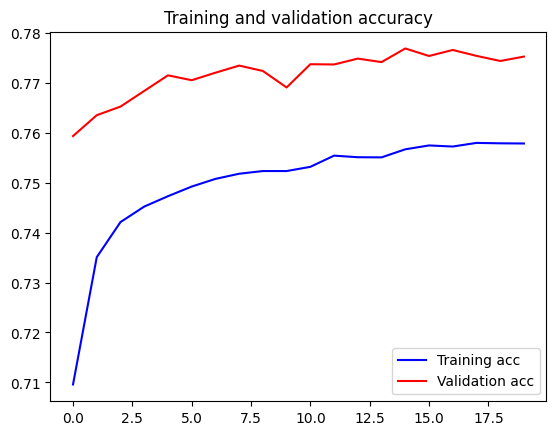

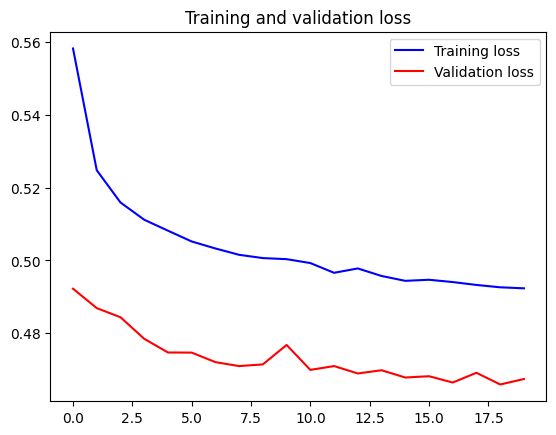

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
predict("I'm neutral about this product.")

1/1 [==============================] - 0s 290ms/step


<ipython-input-39-ce960397c26e>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'NEUTRAL',
 'score': 0.6844282150268555,
 'elapsed_time': 0.4041628837585449}

In [ ]:
model.save("model.keras")


In [ ]:
from keras.models import load_model

# Load the pre-trained model
model = load_model('model.keras')


In [ ]:
from keras.models import load_model
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
# import nltk
# from nltk.corpus import stopwords
# from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools


# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024
# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# Load the pre-trained model
model = load_model('model.keras')

tokenizer = Tokenizer()
# tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}


predict("this medicine is neither good or bad")

Total words 1
1/1 [==============================] - 0s 328ms/step


<ipython-input-15-4600692aec83>:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'NEUTRAL',
 'score': 0.580801784992218,
 'elapsed_time': 0.3913381099700928}